In [1]:
import sys

import polars as pl
import torch


from modeling_module.data_loader.MultiPartDataModule import MultiPartDataModule
from modeling_module.data_loader.MultiPartExoDataModule import MultiPartExoDataModule

'''
pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128
https://developer.nvidia.com/cuda-12-8-0-download-archive
'''

MAC_DIR = '/Users/igwanhyeong/PycharmProjects/data_research/raw_data/'
WINDOW_DIR = 'C:/Users/USER/PycharmProjects/research/raw_data/'

if sys.platform == 'win32':
    DIR = WINDOW_DIR
    print(torch.cuda.is_available())
    print(torch.cuda.device_count())
    print(torch.version.cuda)
    print(torch.__version__)
    print(torch.cuda.get_device_name(0))
    print(torch.__version__)
else:
    DIR = MAC_DIR
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

save_dir = DIR + 'fit/20251115_LTB'

ModuleNotFoundError: No module named 'modeling_module'

In [2]:
target_dyn_demand_monthly = pl.read_parquet(DIR + 'target_dyn_demand_monthly.parquet').sort(['oper_part_no', 'demand_dt'])
target_dyn_demand_monthly = (target_dyn_demand_monthly
                                .group_by('oper_part_no', maintain_order = True)
                                .map_groups(lambda g: g.with_columns(pl.arange(1, len(g) + 1).alias('sequence')))
                            )


filtered_target = (target_dyn_demand_monthly
                    .group_by('oper_part_no')
                    .agg(pl.col('sequence').max().alias('sequence_max'))
                    .filter(pl.col('sequence_max') > 43)
                    .select('oper_part_no')
                   ) # seq Q75

target_dyn_demand_monthly = (target_dyn_demand_monthly
                                .join(filtered_target, on = 'oper_part_no', how = 'right')
                                .select(['oper_part_no', 'demand_dt', 'sequence', 'demand_qty'])
                             )
target_dyn_demand_monthly


oper_part_no,demand_dt,sequence,demand_qty
str,i64,i64,f64
"""08141-06203""",201801,1,155.0
"""08141-06203""",201803,2,635.0
"""08141-06203""",201804,3,15.0
"""08141-06203""",201805,4,53.0
"""08141-06203""",201806,5,980.0
…,…,…,…
"""E4200-05532""",202607,82,3.0
"""E4200-05532""",202608,83,1.0
"""E4200-05532""",202611,84,1.0


In [3]:
target_dyn_demand = pl.read_parquet(DIR + 'parquets/dyn_demand.parquet').drop('part_no')

In [4]:
from resources.util.preprocess_util.demand_resampler import DemandResampler

resampler = DemandResampler(
    target_dyn_demand,
    name_col="oper_part_no",
    date_col="demand_dt",
    target_col="demand_qty",
    date_fmt="%Y%m%d",
)

# 1) 주간: Date + iso_yyyyww
weekly_df = resampler.to_weekly_filled(as_int=False, add_iso_yyyyww=True)
weekly_df

oper_part_no,demand_dt,demand_qty,iso_yyyyww
str,date,f64,i64
"""0001-1001""",2018-03-12,5.0,201811
"""0001-1001""",2018-03-19,0.0,201812
"""0001-1001""",2018-03-26,0.0,201813
"""0001-1001""",2018-04-02,0.0,201814
"""0001-1001""",2018-04-09,0.0,201815
…,…,…,…
"""ZZ90239""",2023-05-22,0.0,202321
"""ZZ90239""",2023-05-29,0.0,202322
"""ZZ90239""",2023-06-05,0.0,202323


In [5]:
from resources.util.preprocess_util.intermittent_demand_detector import IntermittentConfig, IntermittentDemandDetector

cfg = IntermittentConfig(
    name_col="oper_part_no",
    target_col="demand_qty",
    adi_threshold=1.32,
    cv2_threshold=0.49,
    count_threshold=20,   # 20 미만은 사실상 0으로 취급
    use_cv2=True,
    min_periods=20,
)

detector = IntermittentDemandDetector(weekly_df, config=cfg)

# 1) 간헐 여부 플래그만
sparsity_flag = detector.detect(return_stats=False)
# → oper_part_no | is_sparsity

# 2) 수요 유형(smooth / erratic / intermittent / lumpy / insufficient)
demand_type = detector.classify(return_stats=False)
# → oper_part_no | demand_type

# 3) 타입 + ADI / CV²까지 같이 보고 싶을 때
demand_type_detail = detector.classify(return_stats=True)
# → oper_part_no | demand_type | is_sparsity | n_periods | ... | ADI | CV2

In [6]:
demand_type_detail

oper_part_no,demand_type,is_sparsity,n_periods,n_zero,n_nz,zero_ratio,ADI,CV2
str,str,bool,u32,u32,u32,f64,f64,f64
"""T2305-25341""","""insufficient""",false,1,1,0,1.0,null,null
"""V025-401""","""insufficient""",false,178,178,0,1.0,null,null
"""M301210""","""insufficient""",false,285,285,0,1.0,null,null
"""P6270-83152""","""intermittent""",true,316,254,62,0.803797,5.096774,0.188961
"""T2185-21243""","""insufficient""",false,318,318,0,1.0,null,null
…,…,…,…,…,…,…,…,…
"""3688C018""","""insufficient""",false,195,195,0,1.0,null,null
"""T5855-21401""","""insufficient""",false,299,299,0,1.0,null,null
"""T4681-82982OE""","""insufficient""",false,1,1,0,1.0,null,null


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\USER\python\py312\Lib\site-packages\torch\__init__.py:1546: UserWarning: This API is going to be deprecated, please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:81.)
  return _C._get_float32_matmul_precision()
You are using a CUDA device ('NVIDIA GeForce RTX 5080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type              | Params | Mode 
--------------------------------------

Epoch 49: 100%|██████████████████| 1/1 [00:00<00:00, 82.13it/s, v_num=0, train_loss_step=4.850, train_loss_epoch=4.870]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 134.20it/s]
Epoch 99: 100%|█| 1/1 [00:00<00:00, 65.24it/s, v_num=0, train_loss_step=4.330, train_loss_epoch=4.350, valid_loss=5.070
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 96.83it/s]
Epoch 149: 100%|█| 1/1 [00:00<00:00, 63.83it/s, v_num=0, train_loss_step=4.130, train_loss_epoch=4.160, valid_loss=5.45
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.76it/s]
MAE (h=12): 20.6051


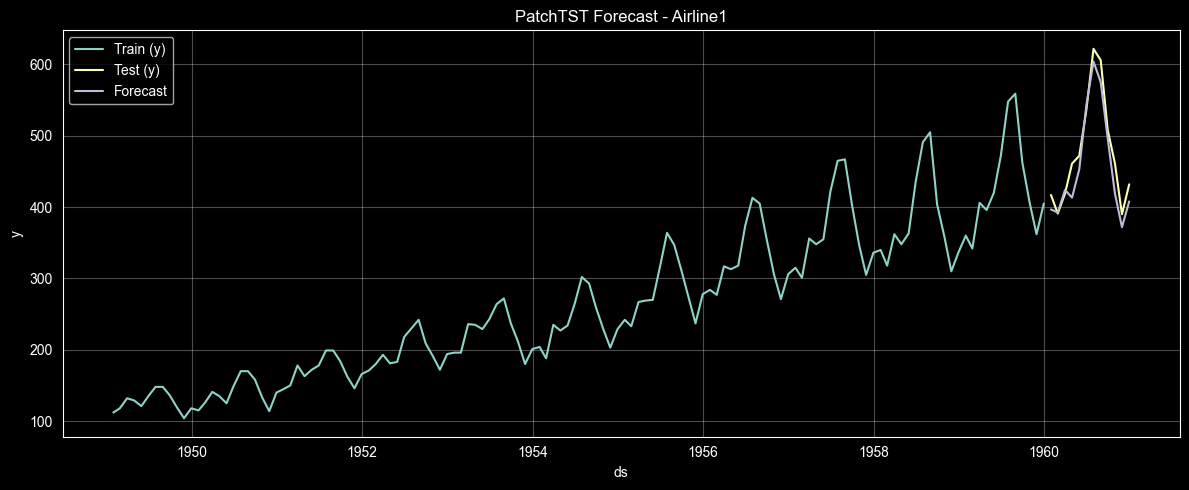

In [3]:
from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import PatchTST
from neuralforecast.losses.pytorch import DistributionLoss
from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic, augment_calendar_df


def train_test_split_last_horizon(df: pd.DataFrame, h: int) -> tuple[pd.DataFrame, pd.DataFrame]:
    df = df.sort_values(["unique_id", "ds"]).reset_index(drop=True)
    test_mask = df.groupby("unique_id").cumcount(ascending=False) < h
    return df[~test_mask].copy(), df[test_mask].copy()


def main():
    # 1) 데이터 + 캘린더 exog
    y_df, calendar_cols = augment_calendar_df(df=AirPassengersPanel, freq="M")

    # 2) split
    h = 12
    y_train_df, y_test_df = train_test_split_last_horizon(y_df, h=h)

    # 3) 모델 (핵심: scaler_type을 robust -> standard/identity로 변경)
    model = PatchTST(
        h=h,
        input_size=104,
        patch_len=24,
        stride=24,

        # 선택 1) MPS 호환: standard
        scaler_type="standard",

        # 선택 2) 스케일링 없이 RevIN으로만 처리하고 싶으면:
        # scaler_type="identity",
        # revin=True,

        hidden_size=16,
        n_heads=4,
        loss=DistributionLoss(distribution="StudentT", level=[80, 90]),

        learning_rate=1e-3,
        max_steps=500,
        val_check_steps=50,
        early_stop_patience_steps=2,
        accelerator='cuda'
    )

    nf = NeuralForecast(models=[model], freq="ME")

    # 4) fit
    nf.fit(df=y_train_df, static_df=AirPassengersStatic, val_size=h)

    # 5) predict
    fcst = nf.predict(futr_df=y_test_df).reset_index(drop=False)

    # 6) MAE (median 우선)
    merged = y_test_df.merge(fcst, on=["unique_id", "ds"], how="inner")
    pred_col = "PatchTST-median" if "PatchTST-median" in merged.columns else "PatchTST"
    mae = float(np.mean(np.abs(merged["y"].to_numpy() - merged[pred_col].to_numpy())))
    print(f"MAE (h={h}): {mae:.4f}")

    # 7) plot (첫 uid만)
    uid = merged["unique_id"].iloc[0]
    tr = y_train_df[y_train_df["unique_id"] == uid].copy()
    te = merged[merged["unique_id"] == uid].copy()

    plt.figure(figsize=(12, 5))
    plt.plot(tr["ds"], tr["y"], label="Train (y)")
    plt.plot(te["ds"], te["y"], label="Test (y)")
    plt.plot(te["ds"], te[pred_col], label="Forecast")
    plt.title(f"PatchTST Forecast - {uid}")
    plt.xlabel("ds")
    plt.ylabel("y")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()


In [4]:
from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 경고 메시지 제어 (선택 사항)
import logging
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

from neuralforecast import NeuralForecast
from neuralforecast.models import PatchTST
from neuralforecast.losses.pytorch import DistributionLoss
from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic, augment_calendar_df


def train_test_split_last_horizon(df: pd.DataFrame, h: int) -> tuple[pd.DataFrame, pd.DataFrame]:
    # 정렬 후 분할
    df = df.sort_values(["unique_id", "ds"]).reset_index(drop=True)
    test_mask = df.groupby("unique_id").cumcount(ascending=False) < h
    return df[~test_mask].copy(), df[test_mask].copy()


def main():
    # 1) 데이터 + 캘린더 외생변수 생성
    # calendar_cols에는 ['month_1', ... 'day_of_week_0' ...] 같은 컬럼명 리스트가 담깁니다.
    y_df, calendar_cols = augment_calendar_df(df=AirPassengersPanel, freq="M")

    # 2) 데이터 분할
    # 주의: y_train_df와 y_test_df 모두에 calendar_cols(외생변수 값)가 포함되어 있어야 합니다.
    h = 12
    y_train_df, y_test_df = train_test_split_last_horizon(y_df, h=h)

    # 3) 모델 정의
    model = PatchTST(
        h=h,
        input_size=104,
        patch_len=24,
        stride=24,

        # --- [핵심 변경 사항] 외생변수 등록 ---
        # 달력 변수는 미래 시점(예측 구간)에도 값을 알 수 있으므로 futr_exog_list에 넣습니다.
        futr_exog_list=calendar_cols,
        # ----------------------------------

        scaler_type="standard",
        hidden_size=16,
        n_heads=4,
        loss=DistributionLoss(distribution="StudentT", level=[80, 90]),

        learning_rate=1e-3,
        max_steps=500,
        val_check_steps=50,
        early_stop_patience_steps=2,

        # GPU 사용 시 'cuda', CPU 사용 시 'cpu' + devices=1
        accelerator='cuda',
        # devices=1  # cuda 사용 시에는 생략 가능 (cpu 사용시 필수)
    )

    nf = NeuralForecast(models=[model], freq="ME")

    # 4) 학습 (Fit)
    # y_train_df 안에 이미 calendar_cols 데이터가 들어있으므로 그대로 사용됩니다.
    nf.fit(df=y_train_df, static_df=AirPassengersStatic, val_size=h)

    # 5) 예측 (Predict)
    # y_test_df(미래 데이터)에 calendar_cols 값이 포함되어 있어야 모델이 이를 참조하여 예측합니다.
    fcst = nf.predict(futr_df=y_test_df).reset_index(drop=False)

    # 6) 평가 (MAE)
    merged = y_test_df.merge(fcst, on=["unique_id", "ds"], how="inner")
    pred_col = "PatchTST-median" if "PatchTST-median" in merged.columns else "PatchTST"

    mae = float(np.mean(np.abs(merged["y"].to_numpy() - merged[pred_col].to_numpy())))
    print(f"MAE (h={h}): {mae:.4f}")

    # 7) 시각화
    uid = merged["unique_id"].iloc[0]
    tr = y_train_df[y_train_df["unique_id"] == uid].copy()
    te = merged[merged["unique_id"] == uid].copy()

    plt.figure(figsize=(12, 5))
    plt.plot(tr["ds"], tr["y"], label="Train (y)")
    plt.plot(te["ds"], te["y"], label="Test (y)")
    plt.plot(te["ds"], te[pred_col], label="Forecast (with Exog)")
    plt.title(f"PatchTST Forecast with Calendar Features - {uid}")
    plt.xlabel("ds")
    plt.ylabel("y")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()

Seed set to 1


Exception: PatchTST does not support future exogenous variables.